## IDS576 - Team 3
#### 1) Training CIFAR Models:
- RFN Model config, with no RFN, but with Adversarial Training
- RFN Model config with Both RFN and Adversarial Training 

#### 2) Evaluate with FSGM Adversary Samples

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Import CIFAR dataset and prepare for training

In [5]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

def denormalize(tensor):
    denorm_tensor = tensor.clone().detach()
    for t, mean, std in zip(denorm_tensor, train_mean, train_std):
        t.mul_(std).add_(mean)
    return denorm_tensor.int().clamp(min=0, max=255)

def visualize_mask(orig, mask, inp):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    #fig.suptitle(f'FGSM sample with epsilon = {eps}', y=.8)
    ax[0].set_title(f'Base Input')
    ax[0].imshow(denormalize(orig).cpu().numpy().transpose(1,2,0))
    ax[1].set_title(f'Mask')
    ax[1].imshow(denormalize(mask.cpu().squeeze()).numpy().transpose(1,2,0))
    ax[2].set_title(f'Masked Input')
    ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

In [6]:
# load the training data for determination of mean and std
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)
print(train_mean/255, train_std/255)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [7]:
normalize = transforms.Normalize(
    mean=train_mean/255,
    std=train_std/255)

train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])
    
val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])

In [8]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
full_train_sampler = SubsetRandomSampler(indices)

batch_size = 128 # per paper
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 0 # allows preload of next batch, but greater than zero isn't recommended for cuda ops
pin_memory = True

train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

full_train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=full_train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

test_dl = DataLoader(
    testset, batch_size=batch_size,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [10]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Train models on CIFAR

In [124]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl, adv_train=False, base_model=None, adv_fn=None, eps=None):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    val_accs = []
    val_losses = []
    for epoch in range(epochs):
        since = time.time()
        model.train()
        #i=0
        print(f'Epoch {epoch+1}/{epochs}: [', end='')
        for i, (xb, yb) in enumerate(train_dl):
            # Use FGSM samples in training
            if adv_train:
                xb = adv_fn(base_model, xb, eps=eps)
            
            if not i % mod:
                print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            #i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        
        # Save history
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{val_loss:6.4f}, Val Acc: {val_acc:6.4f} ', end='')
        until = time.time()
        print(f'Elapsed (sec): {until-since:<5.1f}')
    return val_accs, val_losses

#### Define models from paper appendix

In [12]:
class CIFAR_Standard(nn.Module):
    
    def __init__(self):
        super(CIFAR_Standard, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return x

In [13]:
class CIFAR_Dropout(nn.Module):
    
    def __init__(self):
        super(CIFAR_Dropout, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x


In [14]:
class CIFAR_RFN(nn.Module):
    
    def __init__(self):
        super(CIFAR_RFN, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 128 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

In [117]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Calculate shape values for x
        self.shape_vals = x.size(), x[0].size(), x[0].nelement()
        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

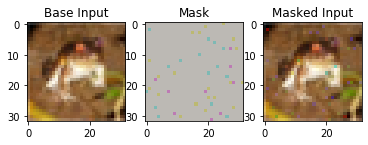

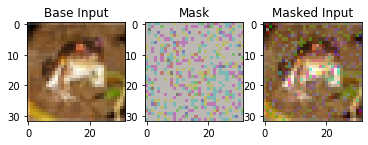

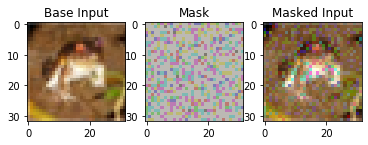

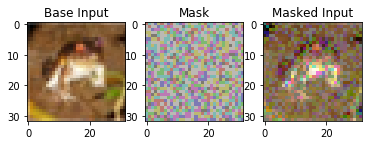

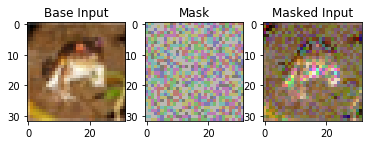

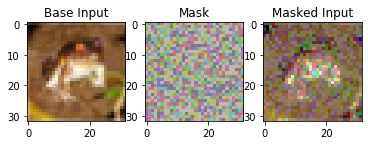

In [122]:
for mu in [0,.1,.2,.3,.4,.5]:
    example_rfn_wrapper = RFN(CIFAR_Standard(), mu=mu, sigma=0.05, rfn_flag=True)
    inp = trainset[0][0]
    mask = example_rfn_wrapper.random_masks(inp.unsqueeze(0))
    visualize_mask(inp, mask, mask.cpu()*inp)

In [135]:
# Create dictionary to store training history for all models
models = {'AdvTrn': CIFAR_RFN()}
rfn_mu_vals = [0, .5]

history = {}
for model_name in models.keys():
    history[model_name] = {}
    for mu in rfn_mu_vals:
        history[model_name][mu] = {}

In [136]:
# Train model with adversarial samples and then with adv samples and RFN=50 using paper hyperparameters
# Given previous experiement with epochs, skipping directly to 20 epochs and test eval

models = {'AdvTrn': CIFAR_RFN()}
base_model = CIFAR_RFN()
base_model.load_state_dict(torch.load(f'./models/Full_CIFAR_RFN_0.pth'))
base_model.to(device)

adv_train = True
rfn_mu_vals = [0, .5]
eps = 40
epochs = 20

for model_name, model_instance in models.items():
    print()
    for mu in rfn_mu_vals:    
        # Set whether RFN will be used in training
        if mu == 0:
            rfn_flag = False
        else:
            rfn_flag = True
            
        print(f'Training {model_name}: RFN={rfn_flag}, mu={mu}:')     
        model = model_instance
        model.to(device)
        rfn_wrapper = RFN(model, mu=mu, sigma=.05, rfn_flag=rfn_flag)
        rfn_wrapper.to(device)
        
        criterion = nn.CrossEntropyLoss()
        loss_func = nn.CrossEntropyLoss()
        opt = optim.Adam(model.parameters(), lr=0.001) # Opt and LR per paper
        
        # Save tuple of epoch val accuracy and val loss to history dict
        history[model_name][mu] = fit(epochs, rfn_wrapper, loss_func, opt, full_train_dl, test_dl,\
                                     adv_train=adv_train, base_model=base_model, adv_fn=fgsm_batch, eps=eps)

        # Save model
        PATH = f'./models/Full_CIFAR_{model_name}_{mu}.pth'
        torch.save(model.state_dict(), PATH)


Training AdvTrn: RFN=False, mu=0:
Epoch 1/20: [****] Val Loss: 1.3013, Val Acc: 0.5345 Elapsed (sec): 38.5 
Epoch 2/20: [****] Val Loss: 1.0906, Val Acc: 0.6153 Elapsed (sec): 39.1 
Epoch 3/20: [****] Val Loss: 1.0019, Val Acc: 0.6449 Elapsed (sec): 38.6 
Epoch 4/20: [****] Val Loss: 0.9398, Val Acc: 0.6743 Elapsed (sec): 38.9 
Epoch 5/20: [****] Val Loss: 0.9030, Val Acc: 0.6884 Elapsed (sec): 39.7 
Epoch 6/20: [****] Val Loss: 0.9325, Val Acc: 0.6830 Elapsed (sec): 39.2 
Epoch 7/20: [****] Val Loss: 0.9511, Val Acc: 0.6767 Elapsed (sec): 38.5 
Epoch 8/20: [****] Val Loss: 0.9098, Val Acc: 0.6896 Elapsed (sec): 39.1 
Epoch 9/20: [****] Val Loss: 0.9257, Val Acc: 0.6910 Elapsed (sec): 41.1 
Epoch 10/20: [****] Val Loss: 0.9391, Val Acc: 0.6938 Elapsed (sec): 41.8 
Epoch 11/20: [****] Val Loss: 0.9054, Val Acc: 0.7035 Elapsed (sec): 41.9 
Epoch 12/20: [****] Val Loss: 0.9484, Val Acc: 0.7027 Elapsed (sec): 41.6 
Epoch 13/20: [****] Val Loss: 0.9411, Val Acc: 0.7036 Elapsed (sec): 41.5 

In [141]:
import pickle
with open('./models/fulltrain20_adv_cifar_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [142]:
with open('./models/fulltrain20_adv_cifar_history.pkl', 'rb') as f:
    history = pickle.load(f)

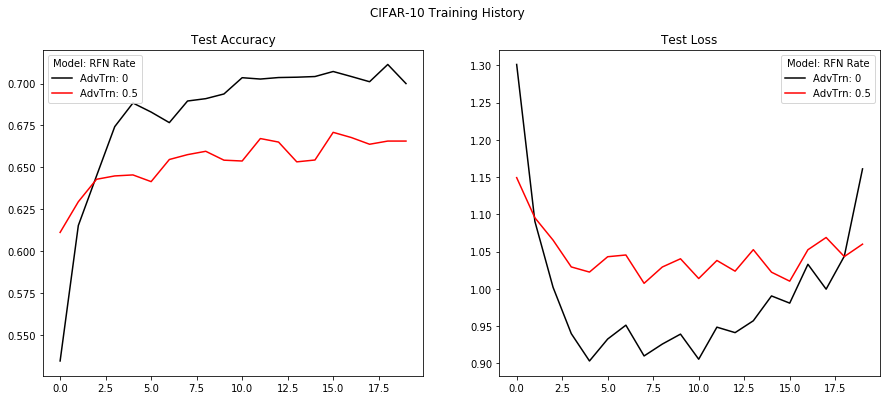

In [148]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']
linestyles = ['-', '-.', '--'] #Standard=solid, Dropout=dashdot, RFN=dash

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle('CIFAR-10 Training History')
ax[0].set_title('Test Accuracy')
ax[1].set_title('Test Loss')
for linestyle, model_name in zip(linestyles, models.keys()):
    for color, (mu, vals) in zip(colors, history[model_name].items()):
        try:
            acc, loss = vals
            ax[0].plot(range(len(acc)), acc, color+linestyle, label=f'{model_name}: {mu}')
            ax[1].plot(range(len(loss)), loss, color+linestyle, label=f'{model_name}: {mu}')
        except:
            continue
ax[0].legend(title='Model: RFN Rate')
ax[1].legend(title='Model: RFN Rate')

#### Evaluate Models with FSGM Samples

In [149]:
def fgsm_batch(net, orig, eps=15):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = prior_out.argmax(axis=1)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    #loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss = criterion(prior_out, prior_pred)
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [166]:
def evaluate(net, dataloader, eps=15, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = eps)
        preds = net(inputs)
        for pred, label in zip(preds, labels):
            if torch.argmax(pred) == label:
                correct += 1.0
            count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc

In [167]:
# Create accuracy dictionary
models = {'AdvTrn': CIFAR_RFN()}
rfn_mu_vals = [0, .5]
epsilons = [0, 40, 60, 90]

analysis = {}
for model_name in models.keys():
    analysis[model_name] = {}
    for mu in rfn_mu_vals:
        analysis[model_name][mu] = {}
        for eps in epsilons:
            analysis[model_name][mu][eps] = []

In [172]:
# load CIFAR models
'''val_dl = DataLoader(
    valset, batch_size=1, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)'''

models = {'AdvTrn': CIFAR_RFN()}
rfn_mu_vals = [0, .5]
epsilons = [0, 40, 60, 90]  # Corresponds to 0 .15, .25, and .35 in paper

# Evaluate pretrained CIFAR CNNs with and without FSGM attack, set sigma on RFN = 0 
for model_name, model_instance in models.items():
    print()
    for eps in epsilons:
        if eps == 0:
            adv = False
        else:
            adv = True
        for mu in rfn_mu_vals:
            if mu == 0:
                rfn_flag = False
            else:
                rfn_flag = True

            model = model_instance
            # Set sigma to zero per paper
            rfn_wrapper = RFN(model, mu=mu, sigma=0, rfn_flag=rfn_flag)
            # Trained on Train data:
            #model.load_state_dict(torch.load(f'./models/CIFAR_{model_name}_{mu}.pth'))
            
            # Trained on Full Train data:
            model.load_state_dict(torch.load(f'./models/Full_CIFAR_{model_name}_{mu}.pth'))
            model.to(device)
            model.eval()
            criterion = nn.CrossEntropyLoss()

            print(f'Evaluate CIFAR {model_name}, eps={eps}, mu={mu}:')
            analysis[model_name][mu][eps] = evaluate(rfn_wrapper, test_dl, eps=eps, adv=adv)



Evaluate CIFAR AdvTrn, eps=0, mu=0:
Sample: 0, Running Accuracy: 0.711
Accuracy over 10000 samples: 0.700
Evaluate CIFAR AdvTrn, eps=0, mu=0.5:
Sample: 0, Running Accuracy: 0.664
Accuracy over 10000 samples: 0.668
Evaluate CIFAR AdvTrn, eps=40, mu=0:
Sample: 0, Running Accuracy: 0.188
Accuracy over 10000 samples: 0.245
Evaluate CIFAR AdvTrn, eps=40, mu=0.5:
Sample: 0, Running Accuracy: 0.555
Accuracy over 10000 samples: 0.542
Evaluate CIFAR AdvTrn, eps=60, mu=0:
Sample: 0, Running Accuracy: 0.195
Accuracy over 10000 samples: 0.237
Evaluate CIFAR AdvTrn, eps=60, mu=0.5:
Sample: 0, Running Accuracy: 0.398
Accuracy over 10000 samples: 0.453
Evaluate CIFAR AdvTrn, eps=90, mu=0:
Sample: 0, Running Accuracy: 0.211
Accuracy over 10000 samples: 0.222
Evaluate CIFAR AdvTrn, eps=90, mu=0.5:
Sample: 0, Running Accuracy: 0.344
Accuracy over 10000 samples: 0.361


In [173]:
import pickle
with open('./models/fulltrain20_adv_cifar_analysis.pkl', 'wb') as f:
    pickle.dump(analysis, f)

with open('./models/fulltrain20_adv_cifar_analysis.pkl', 'rb') as f:
    analysis = pickle.load(f)

In [175]:
print('\t\tFSGM Epsilons:')
print(f'MU  Model\t{0:<5}\t{40:<5}\t{60:<5}\t{90:<5}')
for model_name in models.keys():
    for mu in rfn_mu_vals:
        print(f'{mu:<4}{model_name:<10}\t', end='')
        for eps in epsilons:
            print(f'{analysis[model_name][mu][eps]:.4}\t', end='')
        print()

		FSGM Epsilons:
MU  Model	0    	40   	60   	90   
0   AdvTrn    	0.7	0.2451	0.2374	0.2221	
0.5 AdvTrn    	0.6679	0.5418	0.4527	0.3607	


In [229]:
def visualize_attack(orig, inp):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(f'FGSM sample with epsilon = {eps}', y=.8)
    #ax[0].set_title(f'True: {label}, Pred {prior_pred}')
    ax[0].set_title(f'Pred: {classes[torch.argmax(model(orig.to(device)))]}')
    ax[0].imshow(denormalize(orig.squeeze()).cpu().numpy().transpose(1,2,0))
    ax[1].set_title(f'Perturbation')
    #print(inp.type(), inp.size(), orig.type(), orig.size())
    ax[1].imshow(denormalize(inp.cpu() - orig).squeeze().numpy().transpose(1,2,0))
    ax[2].set_title(f'Adv Pred: {classes[torch.argmax(model(inp))]}')
    ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

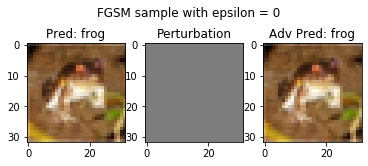

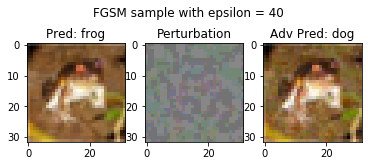

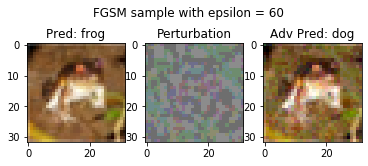

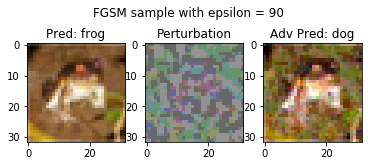

In [230]:
orig = trainset[0][0].unsqueeze(0)
for eps in epsilons:
    inp = fgsm_batch(model, orig, eps=eps)
    visualize_attack(orig, inp)